## Importacion de las librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import pyarrow
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Carga del archivo parquet del data_movies

In [2]:
data_movies = pd.read_parquet('../Source/data_movies.parquet', engine='pyarrow')

## Revisando algunos datos, como cantidad de ceros, NaN, etc.

In [23]:
data_movies.dtypes

budget                      float64
id                            int64
original_language            object
overview                     object
popularity                   object
release_date         datetime64[ns]
revenue                     float64
status                       object
title                        object
vote_average                float64
vote_count                  float64
release_year         datetime64[ns]
return                      float64
genre_name                   object
dtype: object

In [24]:
data_movies.isnull().sum()

budget                 0
id                     0
original_language     17
overview               0
popularity             0
release_date           0
revenue                0
status               124
title                  0
vote_average           0
vote_count             0
release_year           0
return                 0
genre_name             0
dtype: int64

* ### Si tomamos la cantidad total del datasets (93420 filas) vemos que la cantidad de valores nulos no es significativa.

* ### Lo que mas me preocupa es la cantidad de 0 (Ceros)

In [25]:
(data_movies == 0).sum()

budget               71512
id                       0
original_language        0
overview                 0
popularity               0
release_date             0
revenue              74903
status                   0
title                    0
vote_average          4436
vote_count            4261
release_year             0
return               79400
genre_name               0
dtype: int64

### La columna return tiene una cantidad significativa de 0 (Ceros). Esto se debe tambien a como esta calculada. Ya que en la columna de sus operadores tambien hay muchos 0 (Ceros)

### Vamos a analizar un poco mas el dataset

In [3]:
data_movies['budget'] = pd.to_numeric(data_movies['budget'], errors='coerce')
data_movies['popularity'] = pd.to_numeric(data_movies['popularity'], errors='coerce')
data_movies['revenue'] = pd.to_numeric(data_movies['revenue'], errors='coerce')
data_movies['return'] = pd.to_numeric(data_movies['return'], errors='coerce')

### Descripcion del dataset

In [4]:
data_movies.describe()

,budget,id,popularity,release_date,revenue,vote_average,vote_count,release_year,return
count,9.342000e+04,93420.000000,93420.000000,93420,9.342000e+04,93420.000000,93420.000000,93420,9.342000e+04
mean,5.974303e+06,96238.795461,3.518803,1992-06-11 12:57:48.208092672,1.594570e+07,5.706484,146.792860,1970-01-01 00:00:00.000001991,8.674477e+02
min,0.000000e+00,2.000000,0.000000,1874-12-09 00:00:00,0.000000e+00,0.000000,0.000000,1970-01-01 00:00:00.000001874,0.000000e+00
25%,0.000000e+00,20947.000000,0.520849,1979-07-06 00:00:00,0.000000e+00,5.100000,4.000000,1970-01-01 00:00:00.000001979,0.000000e+00
50%,0.000000e+00,49214.000000,1.463661,2001-02-16 00:00:00,0.000000e+00,6.000000,13.000000,1970-01-01 00:00:00.000002001,0.000000e+00
75%,0.000000e+00,125104.500000,4.980211,2010-05-21 00:00:00,0.000000e+00,6.800000,49.000000,1970-01-01 00:00:00.000002010,0.000000e+00
max,3.800000e+08,469172.000000,547.488298,2020-12-16 00:00:00,2.787965e+09,10.000000,14075.000000,1970-01-01 00:00:00.000002020,1.239638e+07
std,2.132934e+07,108204.786088,7.250036,NaN,7.959486e+07,1.737863,592.370343,NaN,8.598586e+04


### Escalamos los datos

In [5]:
data_movies_escalado = data_movies.copy()

escalado = MinMaxScaler()
data_movies_escalado[['budget', 'popularity', 'revenue', 'return']] = escalado.fit_transform(
    data_movies[['budget', 'popularity', 'revenue', 'return']]
)

In [39]:
data_movies_escalado.describe()

,budget,id,popularity,release_date,revenue,vote_average,vote_count,release_year,return
count,93420.000000,93420.000000,93420.000000,93420,93420.000000,93420.000000,93420.000000,93420,93420.000000
mean,0.015722,96238.795461,0.006427,1992-06-11 12:57:48.208092672,0.005719,5.706484,146.792860,1970-01-01 00:00:00.000001991,0.000070
min,0.000000,2.000000,0.000000,1874-12-09 00:00:00,0.000000,0.000000,0.000000,1970-01-01 00:00:00.000001874,0.000000
25%,0.000000,20947.000000,0.000951,1979-07-06 00:00:00,0.000000,5.100000,4.000000,1970-01-01 00:00:00.000001979,0.000000
50%,0.000000,49214.000000,0.002673,2001-02-16 00:00:00,0.000000,6.000000,13.000000,1970-01-01 00:00:00.000002001,0.000000
75%,0.000000,125104.500000,0.009096,2010-05-21 00:00:00,0.000000,6.800000,49.000000,1970-01-01 00:00:00.000002010,0.000000
max,1.000000,469172.000000,1.000000,2020-12-16 00:00:00,1.000000,10.000000,14075.000000,1970-01-01 00:00:00.000002020,1.000000
std,0.056130,108204.786088,0.013242,NaN,0.028549,1.737863,592.370343,NaN,0.006936


In [6]:
data_movies[['budget', 'popularity', 'revenue', 'return']].var()

budget        4.549406e+14
popularity    5.256302e+01
revenue       6.335342e+15
return        7.393567e+09
dtype: float64

### Viendo la alta varianza que tiene estas columnas. Interpreto que es debido tambien al alto rango de diferentes presupuesto que reciben las peliculas. Podemos tener presupuestos de miles de millones hasta presupuestos de miles de dolares.


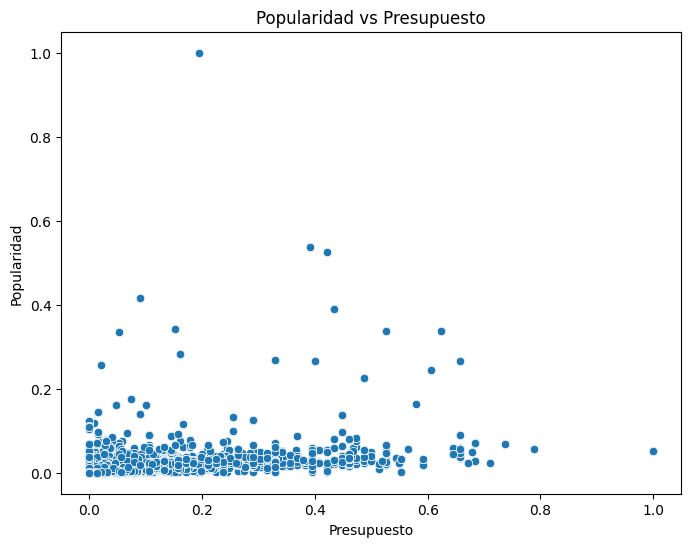

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='budget', y='popularity', data=data_movies_escalado)
plt.title('Popularidad vs Presupuesto')
plt.xlabel('Presupuesto')
plt.ylabel('Popularidad')
plt.show()

<Figure size 1000x600 with 0 Axes>

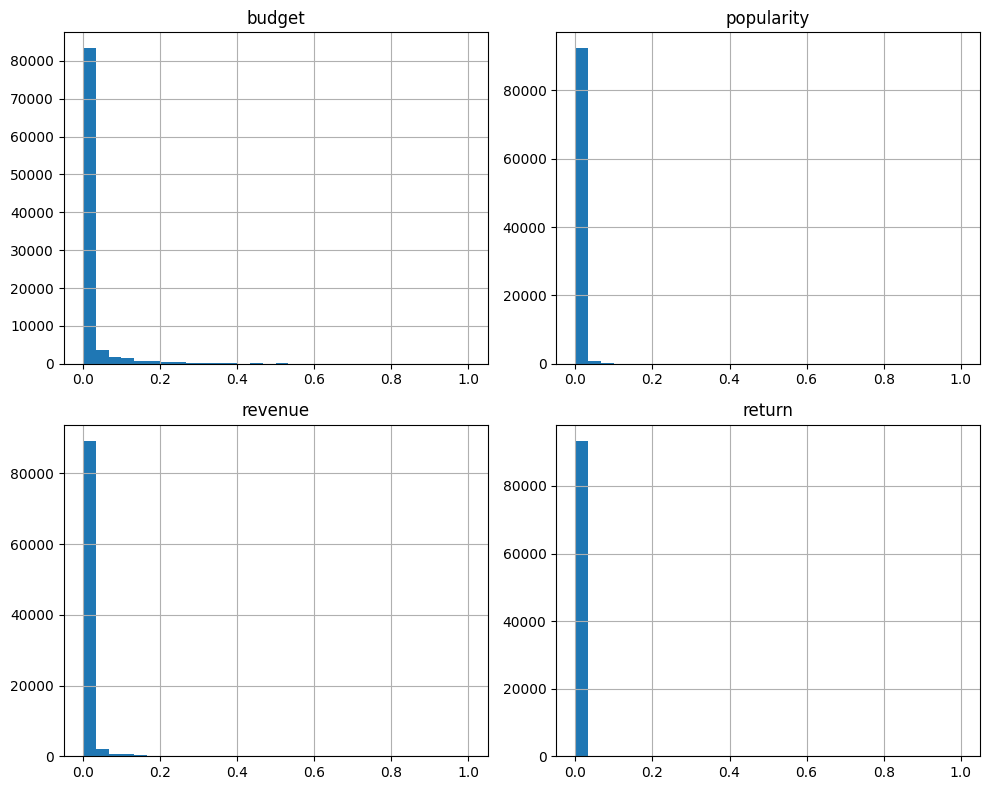

In [8]:
plt.figure(figsize=(10, 6))
data_movies_escalado[['budget', 'popularity', 'revenue', 'return']].hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

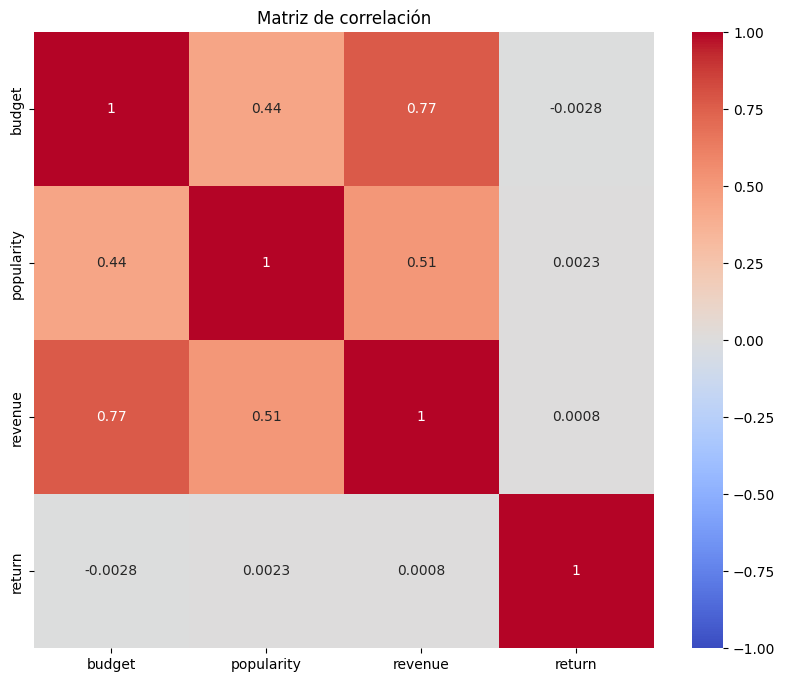

In [9]:
plt.figure(figsize=(10, 8))
correlation_matrix = data_movies_escalado[['budget', 'popularity', 'revenue', 'return']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación')
plt.show()

### En el siguiente grafico tambien se puede ver la valores atipicos de presupuestos y de retornos de las peliculas

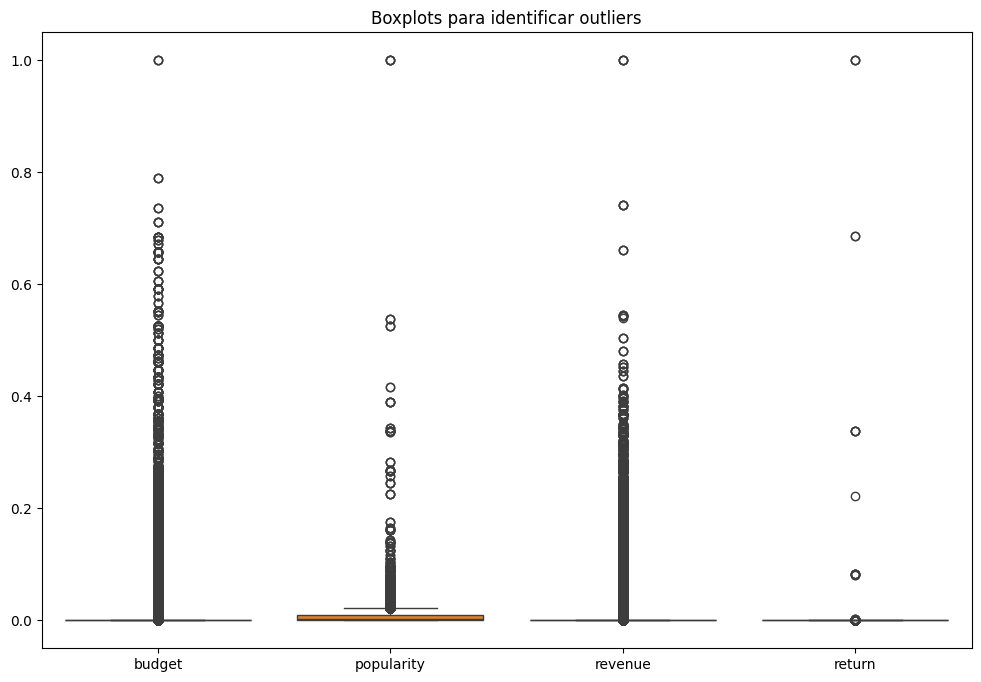

In [10]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data_movies_escalado[['budget', 'popularity', 'revenue', 'return']])
plt.title('Boxplots para identificar outliers')
plt.show()

## Algunas conclusiones:

* Los valores y columnas que mas me interesan no me estan ayudando a hacer un buen desarrollo del problema.
* Tenemos columnas como budget que al ser nulos hacer que la columna retorno tambien sea nula.
* Esto se podria solucionar quizas utilizando promedio de presupuestos para rellenar esas columnas.
* Al ser un problema de MVP vamos a centrarnos en el modelo. Al modelo lo voy a alimentar con el data_movie.
* Voy a utilizar la similitud del coseno con los feacture overview, genres_name y release_year, considerando los mas triviales para la recomendacion.

### Otras consideraciones

* viendo la cantidad de peliculas por genero, podriamos hacer un recorte por Drama, que es uno de los generos mas populares.
* Esto serviria para pasarle a la API.

In [58]:
data_movies.columns

Index(['budget', 'id', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'status', 'title', 'vote_average',
       'vote_count', 'release_year', 'return', 'genre_name'],
      dtype='object')

In [11]:
data_movies['genre_name'].value_counts()

genre_name
Drama              20255
Comedy             13181
Thriller            7619
Romance             6733
Action              6592
Horror              4670
Crime               4305
Documentary         3921
Adventure           3494
Science Fiction     3042
Family              2768
Mystery             2464
None                2384
Fantasy             2313
Animation           1932
Foreign             1621
Music               1598
History             1397
War                 1323
Western             1042
TV Movie             766
Name: count, dtype: int64

In [12]:
# Filtrar las películas que contienen el genero 'Animation' en la columna 'genre_name'
peliculas_animacion = data_movies[data_movies['genre_name'].str.contains('Animation', case=False, na=False)]

peliculas_animacion.head(10)

,budget,id,original_language,overview,popularity,release_date,revenue,status,title,vote_average,vote_count,release_year,return,genre_name
0,30000000.0,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,Released,Toy Story,7.7,5415.0,1970-01-01 00:00:00.000001995,12.451801,Animation
12,0.0,21032,en,An outcast half-wolf risks his life to prevent...,12.140733,1995-12-22,11348324.0,Released,Balto,7.1,423.0,1970-01-01 00:00:00.000001995,0.000000,Animation
47,55000000.0,10530,en,History comes gloriously to life in Disney's e...,13.280069,1995-06-14,346079773.0,Released,Pocahontas,6.7,1509.0,1970-01-01 00:00:00.000001995,6.292360,Animation
235,0.0,15789,en,"Though Goofy always means well, his amiable cl...",10.177977,1995-04-07,35348597.0,Released,A Goofy Movie,6.7,404.0,1970-01-01 00:00:00.000001995,0.000000,Animation
240,0.0,43475,en,The band is back together! Gumby reunites with...,0.090452,1995-12-01,0.0,Released,Gumby: The Movie,5.0,2.0,1970-01-01 00:00:00.000001995,0.000000,Animation
309,35000000.0,22586,en,The beautiful princess Odette is transformed i...,8.910462,1994-11-18,9771658.0,Released,The Swan Princess,6.5,251.0,1970-01-01 00:00:00.000001994,0.279190,Animation
359,45000000.0,8587,en,A young lion cub named Simba can't wait to be ...,21.605761,1994-06-23,788241776.0,Released,The Lion King,8.0,5520.0,1970-01-01 00:00:00.000001994,17.516484,Animation
387,0.0,18242,en,A boy born the size of a small doll is kidnapp...,0.381704,1993-12-10,0.0,Released,The Secret Adventures of Tom Thumb,7.1,8.0,1970-01-01 00:00:00.000001993,0.000000,Animation
546,18000000.0,9479,en,Tired of scaring humans every October 31 with ...,17.730913,1993-10-09,75634409.0,Released,The Nightmare Before Christmas,7.6,2135.0,1970-01-01 00:00:00.000001993,4.201912,Animation
552,27000000.0,15139,en,"Tyler knows a lot about accidents. So much so,...",7.436001,1994-11-23,13670688.0,Released,The Pagemaster,6.2,178.0,1970-01-01 00:00:00.000001994,0.506322,Animation


In [67]:
peliculas_animacion

,budget,id,original_language,overview,popularity,release_date,revenue,status,title,vote_average,vote_count,release_year,return,genre_name
0,30000000.0,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,Released,Toy Story,7.7,5415.0,1970-01-01 00:00:00.000001995,12.451801,Animation
12,0.0,21032,en,An outcast half-wolf risks his life to prevent...,12.140733,1995-12-22,11348324.0,Released,Balto,7.1,423.0,1970-01-01 00:00:00.000001995,0.000000,Animation
47,55000000.0,10530,en,History comes gloriously to life in Disney's e...,13.280069,1995-06-14,346079773.0,Released,Pocahontas,6.7,1509.0,1970-01-01 00:00:00.000001995,6.292360,Animation
235,0.0,15789,en,"Though Goofy always means well, his amiable cl...",10.177977,1995-04-07,35348597.0,Released,A Goofy Movie,6.7,404.0,1970-01-01 00:00:00.000001995,0.000000,Animation
240,0.0,43475,en,The band is back together! Gumby reunites with...,0.090452,1995-12-01,0.0,Released,Gumby: The Movie,5.0,2.0,1970-01-01 00:00:00.000001995,0.000000,Animation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45371,0.0,460135,en,"When Supergirl, Wonder Woman, Batgirl, Bumbleb...",8.413734,2017-08-30,0.0,Released,LEGO DC Super Hero Girls: Brain Drain,10.0,2.0,1970-01-01 00:00:00.000002017,0.000000,Animation
45386,0.0,175457,en,An abstract animation from Walter Ruttmann.,0.177238,1921-12-31,0.0,Released,Opus II,6.7,5.0,1970-01-01 00:00:00.000001921,0.000000,Animation
45388,0.0,184402,de,An abstract animation by Walter Ruttmann.,0.433345,1925-04-09,0.0,Released,Opus IV,6.9,4.0,1970-01-01 00:00:00.000001925,0.000000,Animation
45437,0.0,455661,en,A closeted boy runs the risk of being outed by...,20.821780,2017-06-01,0.0,Released,In a Heartbeat,8.3,146.0,1970-01-01 00:00:00.000002017,0.000000,Animation


***
***

### Analizando data_credits_directores y data_credits_actores

In [13]:
data_credits_actores = pd.read_parquet('../Source/data_credits_actores.parquet')
data_credits_directores = pd.read_parquet('../Source/data_credits_directores.parquet')

In [14]:
data_credits_actores.describe()

,id
count,564892.000000
mean,94039.108192
std,109095.910194
min,2.000000
25%,17006.000000
50%,45220.000000
75%,125077.000000
max,469172.000000


In [15]:
data_credits_directores.describe()

,id
count,49048.00000
mean,108193.18017
std,112410.97699
min,2.00000
25%,26336.75000
50%,59838.50000
75%,157295.00000
max,469172.00000
